# Newtonian Cooling PINN
SKS, 120317406, AM3064, Physics Informed Neural Networks

This notebook is an implementation of Theo Wolf's PINN (https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a). We will test this PINN against a physical system and see how it holds up.

The cooling rate r was found empirically to be 0.007176895662 $\pm$ 0.000358844819 (procedure described in report). We use this value here.



In [34]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [35]:
def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

In [36]:
def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

Text(0.5, 0, 'Time (s)')

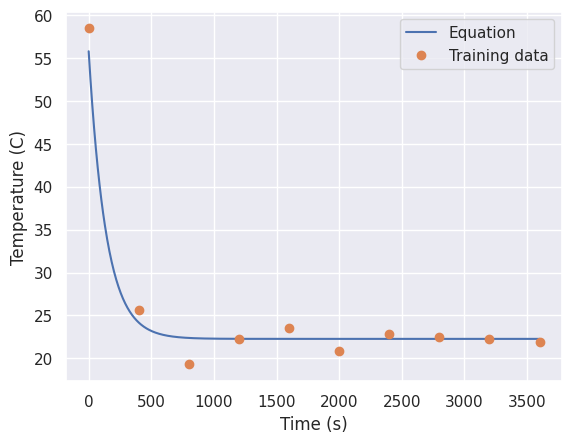

In [44]:
np.random.seed(10)

Tenv = 22.26997747
T0 = 55.81976397
R = 0.007176895662
times = np.linspace(0, 3600, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 3600, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [45]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1200, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

Epoch 0/30000, loss: 2790.65
Epoch 3000/30000, loss: 417.48
Epoch 6000/30000, loss: 293.08
Epoch 9000/30000, loss: 77.29
Epoch 12000/30000, loss: 4.02
Epoch 15000/30000, loss: 2.90
Epoch 18000/30000, loss: 2.65
Epoch 21000/30000, loss: 3.01
Epoch 24000/30000, loss: 2.41
Epoch 27000/30000, loss: 2.40


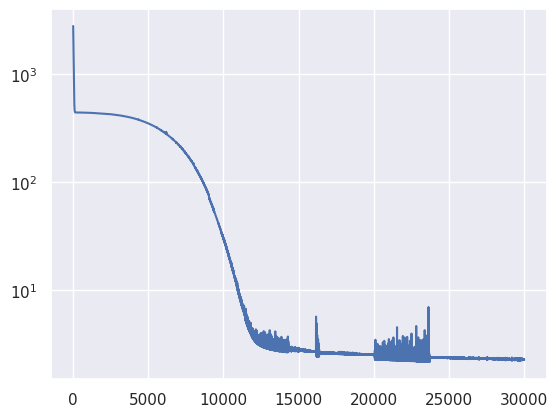

In [46]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

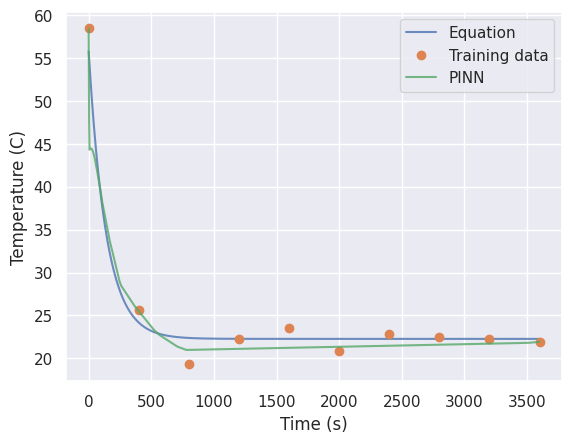

In [47]:
preds = net.predict(times)

# Sarah here: I've altered this to save the cooling data as a csv file, so that I could analyse it.
import csv

f = open('times.csv', 'w')
writer = csv.writer(f)
writer.writerow(times)
f.close()

f = open('temps.csv', 'w')
writer = csv.writer(f)
writer.writerow(temps)
f.close()

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

# Parameter Discovery

The following parts of the notebook deals not with 'solving' Newtonian Cooling (producing a temperature versus time graph), but rather with parameter discovery: finding the cooling rate r. What we want to know here is if the r found by the PINN will fall inside the empirical error margin we found earlier.

In [52]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT

    return torch.mean(pde**2)

Epoch 0/40000, loss: 1025.90
Epoch 4000/40000, loss: 422.53
Epoch 8000/40000, loss: 312.18
Epoch 12000/40000, loss: 92.49
Epoch 16000/40000, loss: 5.08
Epoch 20000/40000, loss: 3.96
Epoch 24000/40000, loss: 3.44
Epoch 28000/40000, loss: 2.98
Epoch 32000/40000, loss: 2.62
Epoch 36000/40000, loss: 2.42


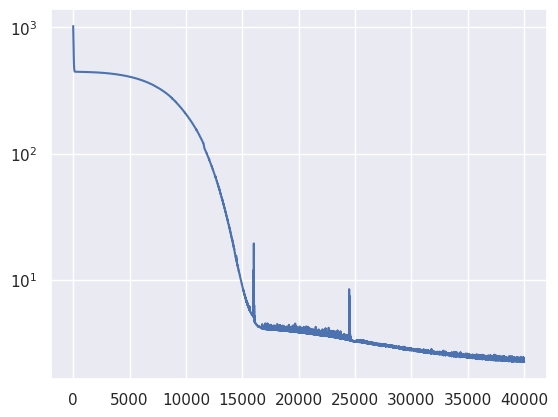

In [53]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0689], requires_grad=True)


Text(0.5, 0, 'Time (s)')

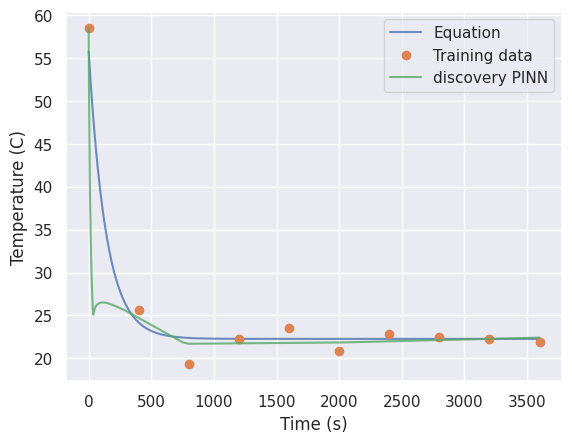

In [54]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')